# CNN

Inspired by:
- https://tf.keras.io/examples/timeseries/timeseries_classification_from_scratch/

## Set-up

In [36]:
import sys, os
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
def singleGraph(df):
    fig = go.Figure()
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col))
    return fig

def tripleGraph(df, fig_title="Test"):
    col_num = 1
    fig = make_subplots(rows=1, cols=3)
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col), row=1, col=col_num)
      col_num += 1
    fig.update_layout(height=1080/2, width=1920/2, title_text=fig_title)
    return fig

def tripleGraph_vertical(df, fig_title="Test"):
    row_num = 1
    fig = make_subplots(rows=3, cols=1)
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col), row=row_num, col=1)
      row_num += 1
    fig.update_layout(height=1920/2, width=1080/2, title_text=fig_title)
    return fig

def comparaisonGraph(df1, df2, fig_title="Test"):    
    col_num = 1
    fig = make_subplots(rows=2, cols=3)
    for col in df1.columns:
        fig.add_trace(go.Scatter(x=df1.index,y=df1[col],name=col), row=1, col=col_num)
        fig.add_trace(go.Scatter(x=df2.index,y=df2[col],name=col), row=2, col=col_num)
        col_num += 1
    fig.update_layout(height=1080/2, width=1920/2, title_text=fig_title)
    return fig

def comparaisonGraph_vertical(df1, df2, fig_title="Test"):    
    row_num = 1
    fig = make_subplots(rows=3, cols=2)
    for col in df1.columns:
        fig.add_trace(go.Scatter(x=df1.index,y=df1[col],name=col), row=row_num, col=1)
        fig.add_trace(go.Scatter(x=df2.index,y=df2[col],name=col), row=row_num, col=2)
        row_num += 1
    fig.update_layout(height=1920/2, width=1080/2, title_text=fig_title)
    return fig

In [37]:
SEPARATOR = ";"

DATE = "2023_04_14"
DATA_FOLDER = os.path.join("../data/android_app/", DATE)

DATA_FILES = [file for file in os.listdir(DATA_FOLDER) if os.path.isfile(os.path.join(DATA_FOLDER, file)) and file.endswith(".txt")]
NB_DATA_FILES = len(DATA_FILES)

MAX_LENGTH = -1

for file in DATA_FILES:
    df = pd.read_csv(os.path.join(DATA_FOLDER, file), sep=SEPARATOR, header=None, names=["ay", "ax", "az"])
    if df.shape[0] > MAX_LENGTH:
        MAX_LENGTH = df.shape[0]

In [38]:
MAX_LENGTH

9489

## Load Data

In [39]:
acc_data = np.empty(shape=[NB_DATA_FILES, 3, MAX_LENGTH])

i = 0
for file in DATA_FILES:
    df = pd.read_csv(os.path.join(DATA_FOLDER, file), sep=SEPARATOR, header=None, names=["ay", "ax", "az"])
    acc = np.array([df["ax"], df["ay"], df["az"]])
    if acc.shape[1] < MAX_LENGTH:
        empty_cols = np.zeros((3, MAX_LENGTH - acc.shape[1]))
        empty_cols[2,:] = 9.81
        acc = np.append(acc, empty_cols, axis=1)
    acc_data[i] = acc
    i += 1

print(type(acc_data))
print(acc_data.shape)
print(acc_data)

<class 'numpy.ndarray'>
(1312, 3, 9489)
[[[ 1.81959330e-01  7.66144540e-02 -1.14921680e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 6.03338840e-01 -9.38527050e-01  4.78840350e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 9.50976900e+00  1.06111020e+01  1.11665560e+01 ...  9.81000000e+00
    9.81000000e+00  9.81000000e+00]]

 [[ 3.83072270e-02  5.74608400e-02  1.81959330e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 7.56567700e-01  8.61912600e-01  6.41646000e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.02184520e+01  1.03046450e+01  9.84495700e+00 ...  9.81000000e+00
    9.81000000e+00  9.81000000e+00]]

 [[ 3.83072270e-02  5.74608400e-02  1.81959330e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-7.56567700e-01 -8.61912600e-01 -6.41646000e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.02184520e+01  1.03046450e+01  9.84495700e+00 ...  9.81000000e+00
    9.81000000e+00  9.8100000

## Load Labels

In [40]:
labels = pd.read_csv(os.path.join(DATA_FOLDER, DATE + ".labels"), sep=",", header=0)
labels = labels.values

acc_data_labels = np.empty(shape=[NB_DATA_FILES, 2], dtype=object)

for i in range(NB_DATA_FILES):
    file = DATA_FILES[i]
    acc_data_labels[i][0] = file
    for j in range(labels.shape[0]):
        if file.startswith(labels[j][0][:-4]):
            acc_data_labels[i][1] = labels[j][1]

# print(type(acc_data_labels))
# print(acc_data_labels.shape)
# print(acc_data_labels)

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(acc_data_labels[:,1])
acc_data_labels[:,1] = encoded_labels

print(type(acc_data_labels))
print(acc_data_labels.shape)
print(acc_data_labels)

<class 'numpy.ndarray'>
(1312, 2)
[['DATA1.txt' 4]
 ['DATA10.txt' 4]
 ['DATA10_i.txt' 4]
 ...
 ['DATA9_r_m.txt' 4]
 ['DATA9_r_m_n.txt' 4]
 ['DATA9_r_n.txt' 4]]


In [41]:
NUM_CLASSES = len(np.unique(acc_data_labels[:,1]))
print(np.unique(acc_data_labels[:,1]))

print(NUM_CLASSES)

[0 1 2 3 4 5 6]
7


## Visualize Data

In [9]:
df = pd.DataFrame(acc_data[0].transpose())
df
tripleGraph(df, acc_data_labels[0][0])

In [10]:
data = pd.read_csv(os.path.join(DATA_FOLDER, "DATA40.txt"), sep=SEPARATOR, header=1, names=["ay", "ax", "az"])
tripleGraph(data)

## Create Train/Test Datasets

In [42]:
idx = np.random.permutation(NB_DATA_FILES)
acc_data = acc_data[idx]
acc_data_labels = acc_data_labels[idx]

# print(acc_data)
# print(acc_data_labels)

In [43]:
TRAIN_PERCENTAGE = 70

NB_TRAIN = int((TRAIN_PERCENTAGE * NB_DATA_FILES) / 100)

print(NB_DATA_FILES)
print(NB_TRAIN)

1312
918


In [44]:
x_train, y_train = acc_data[:NB_TRAIN], acc_data_labels[:NB_TRAIN]
x_test, y_test = acc_data[NB_TRAIN:], acc_data_labels[NB_TRAIN:]
print(x_train.shape[1:])

(3, 9489)


In [45]:
# Shuffle training set -> validation_split later
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

## Build Model

In [47]:
def make_model_classification(input_shape, num_classes):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    gap = tf.keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model_classification(input_shape=x_train.shape[1:], num_classes=NUM_CLASSES)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 3, 9489)]         0         
                                                                 
 conv1d_20 (Conv1D)          (None, 3, 64)             1821952   
                                                                 
 batch_normalization_12 (Ba  (None, 3, 64)             256       
 tchNormalization)                                               
                                                                 
 re_lu_12 (ReLU)             (None, 3, 64)             0         
                                                                 
 conv1d_21 (Conv1D)          (None, 3, 64)             12352     
                                                                 
 batch_normalization_13 (Ba  (None, 3, 64)             256       
 tchNormalization)                                         

In [48]:
def make_model_segmentation(input_shape, num_classes):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    up1 = tf.keras.layers.UpSampling1D(size=2)(conv3)  # Ajustez la taille de l'upsampling si nécessaire
    segmentation_output = tf.keras.layers.Conv1D(num_classes, kernel_size=3, activation="softmax", padding="same")(up1)

    segmentation_model = tf.keras.models.Model(inputs=input_layer, outputs=segmentation_output)
    return segmentation_model

model2 = make_model_segmentation(input_shape=x_train.shape[1:], num_classes=NUM_CLASSES)
model2.summary()
tf.keras.utils.plot_model(model2, show_shapes=True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 3, 9489)]         0         
                                                                 
 conv1d_23 (Conv1D)          (None, 3, 64)             1821952   
                                                                 
 batch_normalization_15 (Ba  (None, 3, 64)             256       
 tchNormalization)                                               
                                                                 
 re_lu_15 (ReLU)             (None, 3, 64)             0         
                                                                 
 conv1d_24 (Conv1D)          (None, 3, 64)             12352     
                                                                 
 batch_normalization_16 (Ba  (None, 3, 64)             256       
 tchNormalization)                                         

In [50]:
import tensorflow as tf

def create_combined_model(classification_model, segmentation_model):
    # Utilisez le modèle de classification comme modèle de base
    inputs = classification_model.input

    adaptation_layer = tf.keras.layers.Reshape((classification_model.output_shape[1], 1))(classification_model.output)

    # Partagez certaines couches entre les deux modèles
    shared_layers = classification_model.layers[:-1]

    # Créez la sortie de segmentation en utilisant le modèle de segmentation
    segmentation_output = segmentation_model(shared_layers[-1].output)

    # Créez le modèle combiné avec une sortie pour la classification et une sortie pour la segmentation
    combined_output = [classification_model.output, segmentation_output]

    combined_model = tf.keras.models.Model(inputs=inputs, outputs=combined_output)
    return combined_model

# Créez le modèle de classification
classification_model = model

# Créez le modèle de segmentation
segmentation_model = model2

# Créez le modèle combiné
combined_model = create_combined_model(classification_model, segmentation_model)

# Compilez et entraînez le modèle combiné
# combined_model.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'])

# Entraînez le modèle avec vos données d'entraînement
# combined_model.fit(x=[classification_data, segmentation_data], y=[classification_labels, segmentation_labels], epochs=epochs)


ValueError: Exception encountered when calling layer "model_2" (type Functional).

Input 0 of layer "conv1d_23" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 64)

Call arguments received by layer "model_2" (type Functional):
  • inputs=tf.Tensor(shape=(None, 64), dtype=float32)
  • training=None
  • mask=None

## Train Model

In [16]:
EPOCHS = 500
BATCH_SIZE = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    np.asarray(y_train[:,1]).astype("short"),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/500
23/23 [==============================] - ETA: 0s - loss: 1.9646 - sparse_categorical_accuracy: 0.2684

C:\Users\julie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



23/23 [==============================] - 13s 195ms/step - loss: 1.9646 - sparse_categorical_accuracy: 0.2684 - val_loss: 2.0861 - val_sparse_categorical_accuracy: 0.0870 - lr: 0.0010
Epoch 2/500
23/23 [==============================] - 3s 134ms/step - loss: 1.6110 - sparse_categorical_accuracy: 0.3774 - val_loss: 1.9871 - val_sparse_categorical_accuracy: 0.0870 - lr: 0.0010
Epoch 3/500
23/23 [==============================] - 3s 132ms/step - loss: 1.3635 - sparse_categorical_accuracy: 0.5232 - val_loss: 1.9319 - val_sparse_categorical_accuracy: 0.0870 - lr: 0.0010
Epoch 4/500
23/23 [==============================] - 3s 127ms/step - loss: 1.2722 - sparse_categorical_accuracy: 0.5504 - val_loss: 1.8367 - val_sparse_categorical_accuracy: 0.2989 - lr: 0.0010
Epoch 5/500
23/23 [==============================] - 3s 124ms/step - loss: 0.9328 - sparse_categorical_accuracy: 0.7466 - val_loss: 1.9006 - val_sparse_categorical_accuracy: 0.0870 - lr: 0.0010
Epoch 6/500
23/23 [======================

## Evaluate Model

In [17]:

model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, np.asarray(y_test[:,1]).astype("short"))

print("Test accuracy", test_acc)
print("Test loss", test_loss)


13/13 [==============================] - 0s 11ms/step - loss: 0.1933 - sparse_categorical_accuracy: 0.9518
Test accuracy 0.9517766237258911
Test loss 0.19332589209079742


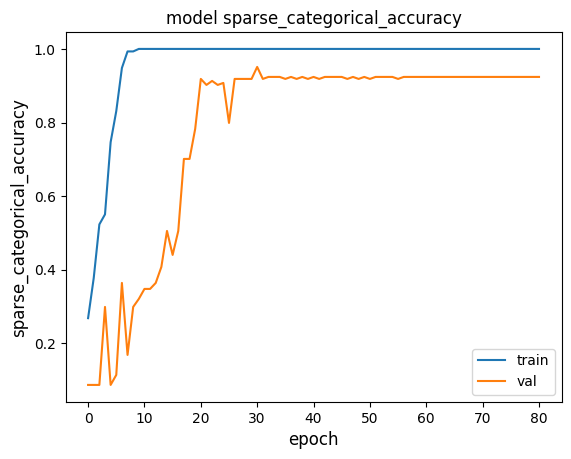

In [18]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


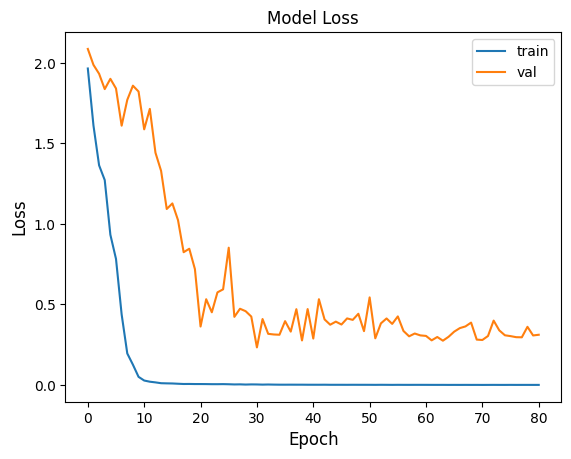

: 

In [20]:
import matplotlib.pyplot as plt

# Crée une nouvelle figure pour le tracé
plt.figure()

# Trace l'historique de la perte sur les données d'entraînement
plt.plot(history.history['loss'])

# Trace l'historique de la perte sur les données de validation
plt.plot(history.history['val_loss'])

# Définit le titre du graphique
plt.title('Model Loss')

# Définit l'étiquette de l'axe des ordonnées (Y) comme "Loss"
plt.ylabel('Loss', fontsize='large')

# Définit l'étiquette de l'axe des abscisses (X) comme "Epoch"
plt.xlabel('Epoch', fontsize='large')

# Ajoute une légende au graphique pour les courbes d'entraînement et de validation
plt.legend(['train', 'val'], loc='best')

# Affiche le graphique
plt.show()

# Ferme la figure après l'affichage
plt.close()



In [ ]:
# Sélectionner une donnée au hasard
random_index = np.random.randint(0, len(acc_data))
random_data = acc_data[random_index]

# Faire la prédiction
predicted_class_probabilities = model.predict(np.expand_dims(random_data, axis=0))[0]
predicted_class_index = np.argmax(predicted_class_probabilities)

# Obtenez la vraie classe à partir des labels
true_class = acc_data_labels[random_index]

# Afficher les résultats
print("Nom de la donnée choisie:", f"acc_data_{random_index}")
print("Classe prédite:", predicted_class_index)
print("Classe réelle:", true_class)

1/1 [==============================] - 0s 144ms/step
Nom de la donnée choisie: acc_data_1088
Classe prédite: 4
Classe réelle: ['DATA9_m.txt' 4]


In [ ]:
import random
import numpy as np
import os

# Données accélérométriques labélisées (exemple)
donnees_accelerometriques = acc_data
etiquettes = acc_data_labels

nouvelles_donnees = []
nouvelles_etiquettes = []


# Paramètres pour le nombre de séquences à générer
nombre_min_sequences = 1
nombre_max_sequences = 5

while True:
    try:
        # Sélection aléatoire du nombre de séquences à prendre
        nombre_sequences = random.randint(nombre_min_sequences, nombre_max_sequences)
        if len(donnees_accelerometriques) < nombre_sequences:
            nombre_sequences = len(donnees_accelerometriques)

        # Sélection des données et étiquettes correspondantes
        nouvelles_sequence = []
        nouvelles_sequence_etiquettes = []

        for i in range(nombre_sequences):
            nouvelle_sequence = donnees_accelerometriques.pop(0)
            nouvelle_sequence_etiquette = etiquettes.pop(0)
            nouvelles_sequence.extend(nouvelle_sequence)
            nouvelles_sequence_etiquettes.append(nouvelle_sequence_etiquette)

        nouvelles_donnees.append(nouvelles_sequence)
        nouvelles_etiquettes.append(nouvelles_sequence_etiquettes)

    except IndexError:
        break

# Enregistrement des données au format texte (.txt)
dossier_sauvegarde = "donnees_sauvegardees"
os.makedirs(dossier_sauvegarde, exist_ok=True)

for i, donnees in enumerate(nouvelles_donnees):
    nom_fichier = os.path.join(dossier_sauvegarde, f"donnees_sequence_{i + 1}.txt")
    np.savetxt(nom_fichier, donnees, delimiter=",")

# Enregistrement des étiquettes au format .label
nom_fichier_label = os.path.join(dossier_sauvegarde, "etiquettes.label")
with open(nom_fichier_label, "w") as fichier_label:
    for etiquettes in nouvelles_etiquettes:
        fichier_label.write(" ".join(map(str, etiquettes)) + "\n")

print("Données enregistrées avec succès.")




AttributeError: 'numpy.ndarray' object has no attribute 'pop'

In [ ]:
#concaténation de 5 séquences
import random

# Fonction pour concaténer les fichiers de données
def concat_data_files(input_prefix, num_files, output_file):
    with open(output_file, 'w') as output:
        for i in range(1, num_files + 1):
            input_file = f"{input_prefix}{i}.txt"
            with open(input_file, 'r') as file:
                output.write(file.read())

# Fonction pour concaténer les fichiers de labels
def concat_label_files(input_prefix, num_files, output_file):
    with open(output_file, 'w') as output:
        for i in range(1, num_files + 1):
            input_file = f"{input_prefix}{i}.label"
            with open(input_file, 'r') as file:
                output.write(file.read())

# Créez 5 fichiers de données aléatoires avec des labels correspondants
for i in range(1, 6):
    data_file = f"data{i}.txt"
    label_file = f"label{i}.label"
    
    # Générez des données aléatoires (remplacez cela par votre propre logique)
    data = [random.randint(0, 100) for _ in range(100)]
    labels = [f"Label_{random.randint(1, 10)}" for _ in range(100)]
    
    # Écrivez les données dans les fichiers correspondants
    with open(data_file, 'w') as data_output, open(label_file, 'w') as label_output:
        for d, label in zip(data, labels):
            data_output.write(f"{d}\n")
            label_output.write(f"{label}\n")

# Concaténez les fichiers de données en un seul fichier
concat_data_files("data", 5, "concatenated_data.txt")

# Concaténez les fichiers de labels en un seul fichier .label
concat_label_files("label", 5, "concatenated_data.label")

print("Fichiers concaténés avec succès.")
